In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json

In [ ]:
auxs = ["ZP", "OP", "bisim_critic"]  # , "ZP_critic"]

envs = []
with open("envs.txt", "r") as envs_file:
    for line in envs_file:
        envs.append(line.strip())

results = dict()

In [3]:
new_cfg_paths = glob.glob("./logs/**/config.json", recursive=True)
for cfg_path in new_cfg_paths:
    res_path = cfg_path.replace("config.json", "progress.csv")
    with open(cfg_path, "r") as cfg_file:
        cfg = json.load(cfg_file)

        env = cfg["env_name"]
        aux = cfg["aux"]
        df = pd.read_csv(res_path)

        if env not in results:
            results[env] = dict()
        if aux not in results[env]:
            results[env][aux] = []
        results[env][aux].append(df)

In [4]:
# orig_cfg_paths = glob.glob("./logs_original/**/config.json", recursive=True)
# for cfg_path in orig_cfg_paths:
#     res_path = cfg_path.replace("config.json", "progress.csv")
#     with open(cfg_path, "r") as cfg_file:
#         cfg = json.load(cfg_file)

#         env = cfg["env_name"]
#         aux = cfg["aux"]
#         try:
#             df = pd.read_csv(res_path)
#         except Exception:
#             pass

#         if env not in results:
#             results[env] = dict()
#         if aux not in results[env]:
#             results[env][aux] = []
#         results[env][aux].append(df)

KeyError: 'bisim'

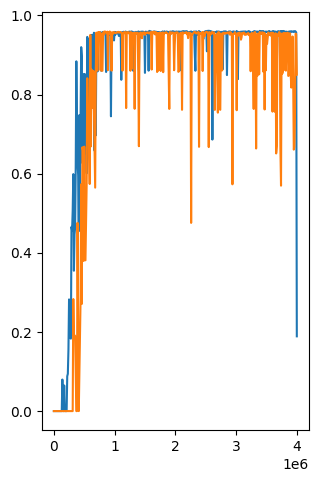

In [5]:
plt.figure(figsize=(20, 25))
i = 1
for env in envs:
    plt.subplot(4, 5, i)

    for aux in auxs:
        dfs = results[env][aux]
        if len(dfs) == 1:
            df = dfs[0]
        else:
            combined = pd.concat(
                [df[["env_steps", "return"]] for df in dfs], ignore_index=True
            )

            def iqm(x):
                q1, q3 = np.percentile(x, [25, 75])
                mask = (x >= q1) & (x <= q3)
                return np.mean(x[mask]) if len(x[mask]) > 0 else np.nan

            df = (
                combined.groupby("env_steps")["return"]
                .agg(iqm)
                .reset_index()
                .sort_values("env_steps")
            )

        valid_idxs = ~df["return"].isna()
        plt.plot(df[valid_idxs]["env_steps"], df[valid_idxs]["return"])

    plt.xlabel("Env Steps")
    plt.ylabel("Return")
    plt.title(env)

    plt.legend(auxs)

    i += 1
plt.show()